<a href="https://colab.research.google.com/github/LW567-lab/Assignment-2-WildfirePrediction/blob/main/forestfire_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Section 1: Data Cleaning & Feature Engineering

In [261]:
from google.colab import drive


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [262]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/forestfires.csv')
print("✅ Original dataset loaded. Shape:", df.shape)

✅ Original dataset loaded. Shape: (517, 13)


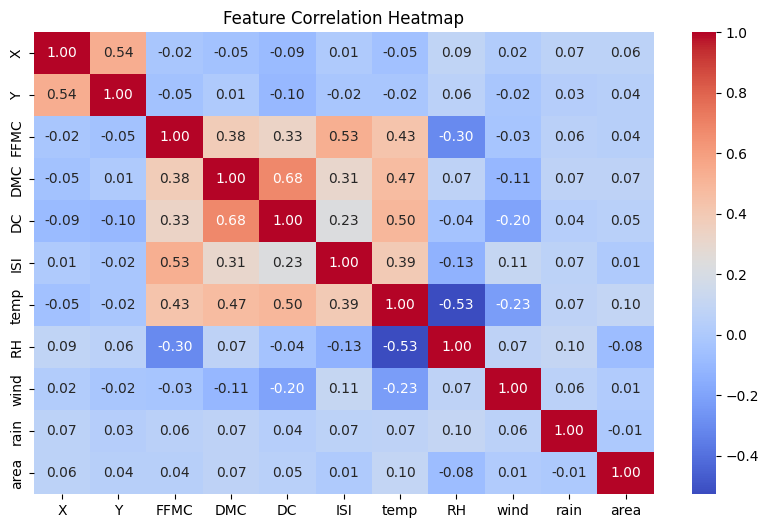

In [263]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_df = df.select_dtypes(include=['number'])

correlation_matrix = numerical_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [264]:
df['area'] = df['area'].clip(
    lower=df['area'].quantile(0.05),
    upper=df['area'].quantile(0.95)
)

In [270]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/forestfires.csv')
print("✅ Original dataset loaded. Shape:", df.shape)

month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
day_map = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}

# Check if 'month' and 'day' columns exist before mapping
if 'month' in df.columns and 'day' in df.columns:
    df['month'] = df['month'].map(month_map)
    df['day'] = df['day'].map(day_map)
else:
    print("⚠️ Columns 'month' or 'day' not found in the DataFrame. Please check your data.")

# Create 'fire_occurred' column based on 'area'
df['fire_occurred'] = (df['area'] > 0).astype(int) # This line was moved up

# The line below was moved after creating 'fire_occurred' column
df.drop(columns=['area', 'X', 'Y', 'rain'], inplace=True)

✅ Original dataset loaded. Shape: (517, 13)


In [257]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['fire_occurred'])
y = df['fire_occurred']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [223]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6538461538461539
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        50
           1       0.66      0.69      0.67        54

    accuracy                           0.65       104
   macro avg       0.65      0.65      0.65       104
weighted avg       0.65      0.65      0.65       104



In [225]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


CV F1 Scores: [0.58064516 0.53333333 0.46511628 0.51851852 0.59574468]
Mean CV F1: 0.5386715946126011
ROC-AUC: 0.6912962962962963


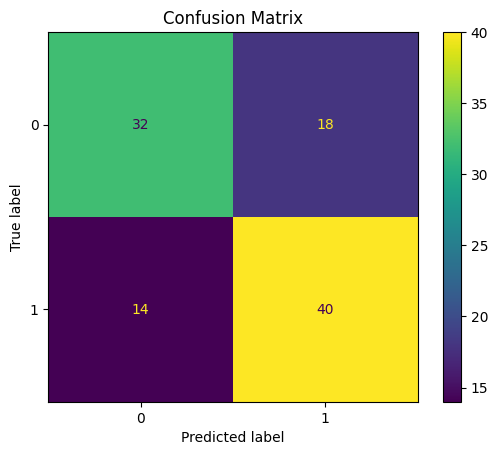

In [226]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Cross-validation F1 score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print("CV F1 Scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

# ROC-AUC
y_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

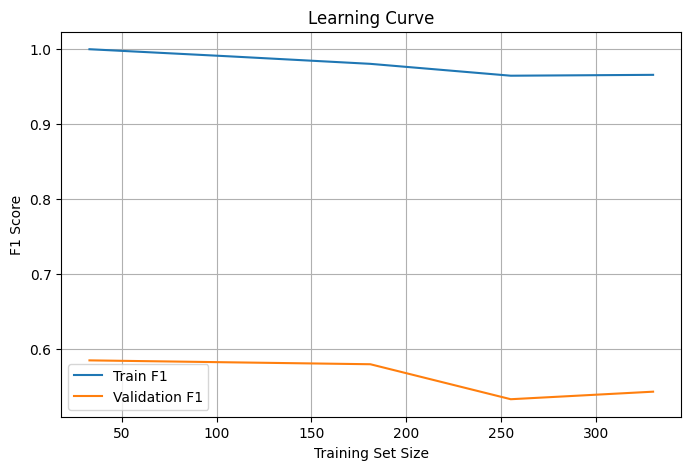

In [227]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5, scoring='f1', n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Train F1")
plt.plot(train_sizes, val_mean, label="Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

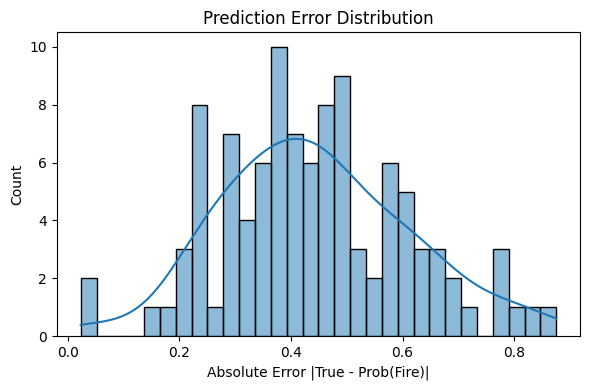

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for class 1
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate absolute error
error = np.abs(y_test - y_proba)

# Plot prediction error distribution
plt.figure(figsize=(6, 4))
sns.histplot(error, bins=30, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Absolute Error |True - Prob(Fire)|")
plt.tight_layout()
plt.show()

Section 2: XGBoost Tuning + Validation + SHAP Interpretability

In [229]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [230]:
y_pred = best_model.predict(X_test)
evaluate(y_test, y_pred, "Tuned XGBoost")

Tuned XGBoost: R² = 0.03, RMSE = 0.49


In [231]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Average R² Score:", scores.mean())

Cross-Validation R² Scores: [-0.0645088  -0.013556   -0.04050934 -0.01742518  0.04484725]
Average R² Score: -0.018230414390563963


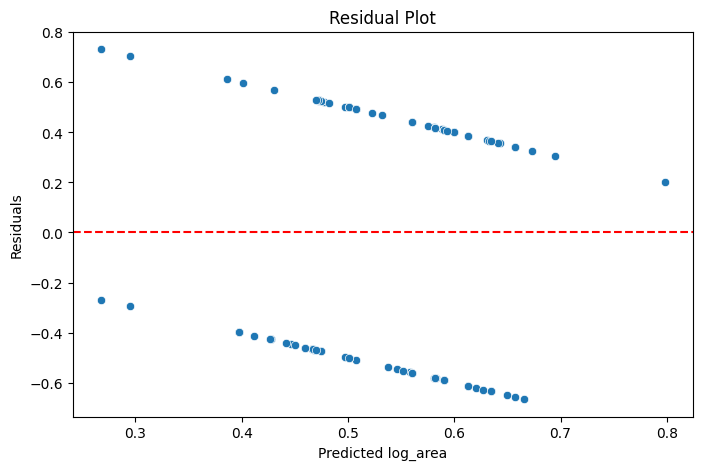

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted log_area")
plt.ylabel("Residuals")
plt.show()

In [233]:
import shap
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

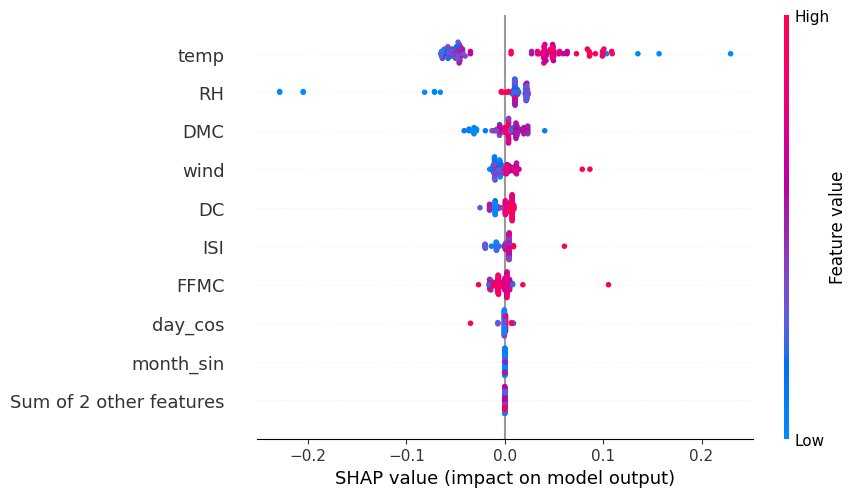

In [234]:
shap.plots.beeswarm(shap_values)

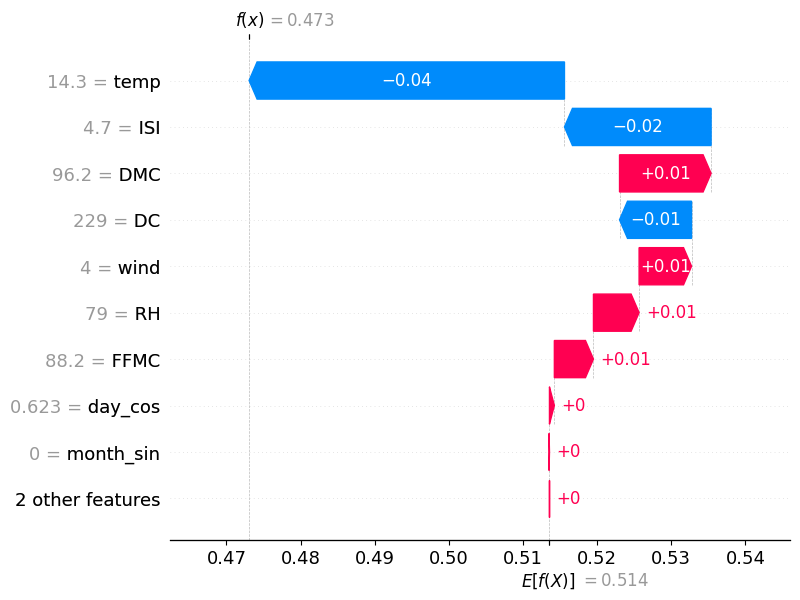

In [235]:
shap.plots.waterfall(shap_values[0])

In [ ]:
Section 3: Regression Modeling – For Comparison Only

In [272]:
# Section 3: Optional Regression Model (For Comparison)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# Reuse original dataset and recreate regression target
df_reg = pd.read_csv('/content/drive/MyDrive/forestfires.csv')
df_reg['area'] = df_reg['area'].clip(
    lower=df_reg['area'].quantile(0.05),
    upper=df_reg['area'].quantile(0.95)
)
df_reg['log_area'] = np.log1p(df_reg['area'])

# Encode time features
df_reg['month'] = df_reg['month'].map(month_map)
df_reg['day'] = df_reg['day'].map(day_map)
df_reg['month_sin'] = np.sin(2 * np.pi * df_reg['month'] / 12)
df_reg['month_cos'] = np.cos(2 * np.pi * df_reg['month'] / 12)
df_reg['day_sin'] = np.sin(2 * np.pi * df_reg['day'] / 7)
df_reg['day_cos'] = np.cos(2 * np.pi * df_reg['day'] / 7)

df_reg.drop(columns=["month", "day", "X", "Y", "rain", "area"], inplace=True)

# Train-test split
X_reg = df_reg.drop(columns=["log_area"])
y_reg = df_reg["log_area"]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Model & tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_r, y_train_r)
best_reg = grid.best_estimator_
y_pred_r = best_reg.predict(X_test_r)

# Evaluation
print("R² (Test):", r2_score(y_test_r, y_pred_r))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_r)))

cv_scores = cross_val_score(best_reg, X_train_r, y_train_r, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())


Fitting 5 folds for each of 8 candidates, totalling 40 fits
R² (Test): 0.02011671115352376
RMSE: 1.317954428850672
Cross-Validation R² Scores: [-0.03180055 -0.0724269  -0.04222467 -0.04238269 -0.00523788]
Mean CV R²: -0.038814538091809105


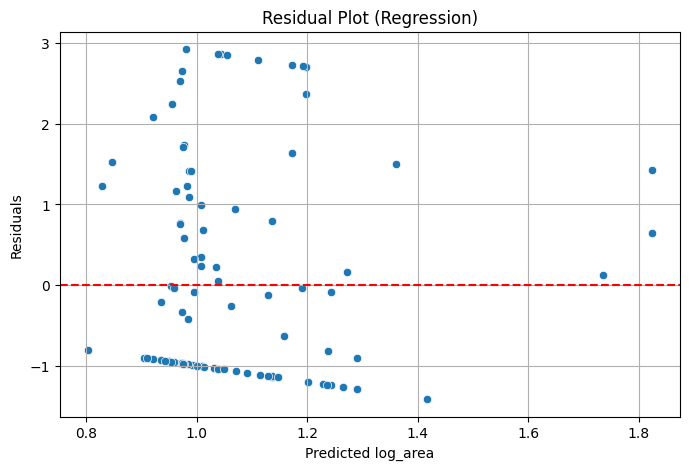

In [273]:
# Residual plot
residuals_r = y_test_r - y_pred_r
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_r, y=residuals_r)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Regression)")
plt.xlabel("Predicted log_area")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

Section 4: Model Saving

In [184]:
import joblib
joblib.dump(best_model, "/content/drive/MyDrive/best_model.pkl")
print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


In [237]:
from google.colab import files
files.download("random_forest_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>